# Day 3: Walk-Forward Validation

## Week 12 - Backtesting & Validation

### 🎯 Learning Objectives
- Understand why K-Fold CV fails for time series
- Implement walk-forward validation from scratch
- Master expanding vs rolling window approaches
- Apply embargo periods correctly

### ⏱️ Time Allocation
- Theory review: 30 min
- Guided exercises: 90 min
- Practice problems: 60 min
- Interview prep: 30 min

---

**Author**: ML Quant Finance Mastery  
**Difficulty**: Intermediate  
**Prerequisites**: Day 1-2

## 1. Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# Generate synthetic financial data
n_samples = 1000

# Features
df = pd.DataFrame({
    'lag_1': np.random.randn(n_samples) * 0.01,
    'lag_5': np.random.randn(n_samples) * 0.01,
    'momentum': np.random.randn(n_samples) * 0.01,
    'volatility': np.abs(np.random.randn(n_samples) * 0.015)
})

# Target with some predictability
df['target'] = (0.1 * df['lag_1'] + 
                0.05 * df['momentum'] - 
                0.1 * df['volatility'] + 
                np.random.randn(n_samples) * 0.01)

print(f"📊 Generated {n_samples} samples of financial data")
print(f"📊 Features: {list(df.columns[:-1])}")

📊 Generated 1000 samples of financial data
📊 Features: ['lag_1', 'lag_5', 'momentum', 'volatility']


## 2. Why K-Fold CV Fails for Time Series

K-Fold shuffles data → uses future to predict past → **LOOKAHEAD BIAS**

📊 CROSS-VALIDATION COMPARISON
Method                    Mean R²         Std        Realistic?
------------------------------------------------------------
K-Fold (WRONG)            -0.0082         0.0084     ❌
TimeSeriesSplit           -0.0067         0.0065     ✅


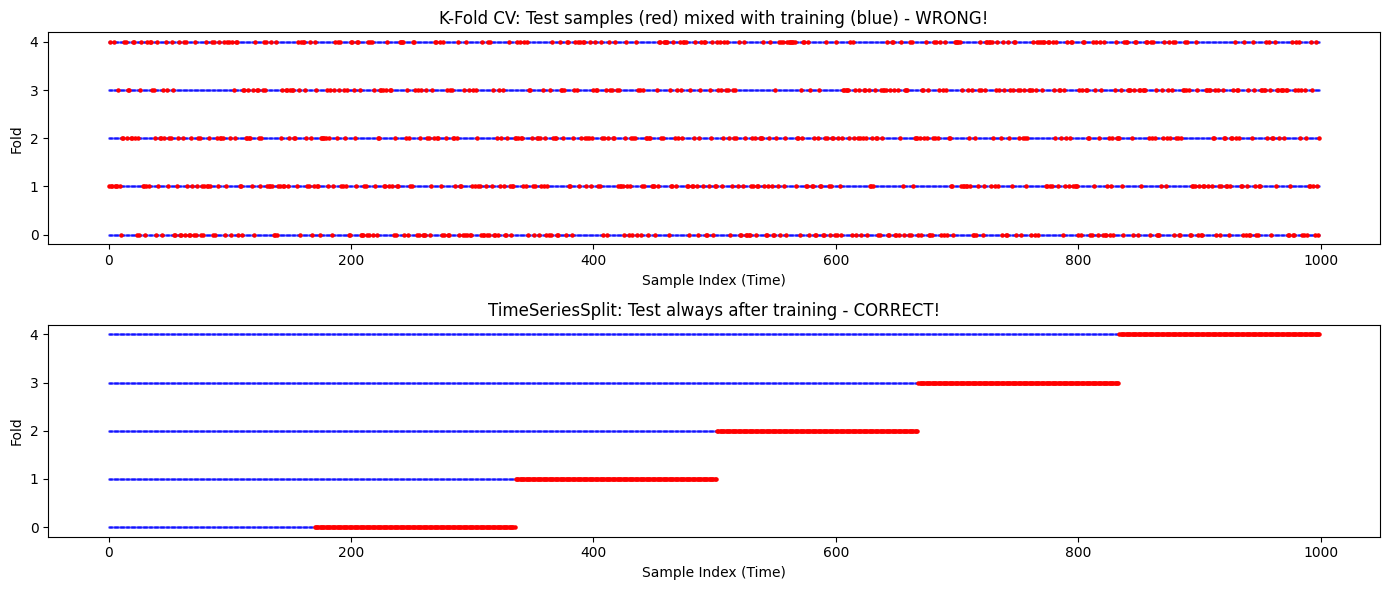

In [2]:
# Demonstrate the problem
X = df[['lag_1', 'lag_5', 'momentum', 'volatility']].values
y = df['target'].values

model = Ridge(alpha=1.0)

# WRONG: K-Fold with shuffling
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

# BETTER: Time Series Split (sklearn)
tscv = TimeSeriesSplit(n_splits=5)
tscv_scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')

print("📊 CROSS-VALIDATION COMPARISON")
print("=" * 60)
print(f"{'Method':<25} {'Mean R²':<15} {'Std':<10} {'Realistic?'}")
print("-" * 60)
print(f"{'K-Fold (WRONG)':<25} {kfold_scores.mean():<15.4f} {kfold_scores.std():<10.4f} ❌")
print(f"{'TimeSeriesSplit':<25} {tscv_scores.mean():<15.4f} {tscv_scores.std():<10.4f} ✅")

# Visualize splits
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# K-Fold visualization
for i, (train_idx, test_idx) in enumerate(kfold.split(X)):
    axes[0].scatter(train_idx, [i]*len(train_idx), c='blue', s=1, alpha=0.5)
    axes[0].scatter(test_idx, [i]*len(test_idx), c='red', s=5)
axes[0].set_xlabel('Sample Index (Time)')
axes[0].set_ylabel('Fold')
axes[0].set_title('K-Fold CV: Test samples (red) mixed with training (blue) - WRONG!')

# TimeSeriesSplit visualization  
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    axes[1].scatter(train_idx, [i]*len(train_idx), c='blue', s=1, alpha=0.5)
    axes[1].scatter(test_idx, [i]*len(test_idx), c='red', s=5)
axes[1].set_xlabel('Sample Index (Time)')
axes[1].set_ylabel('Fold')
axes[1].set_title('TimeSeriesSplit: Test always after training - CORRECT!')

plt.tight_layout()
plt.show()

## 3. Walk-Forward Validation Implementation

In [3]:
class WalkForwardCV:
    """
    Walk-Forward Cross-Validation for Time Series
    
    Two modes:
    - Expanding: Train on all historical data
    - Rolling: Train on fixed window
    """
    
    def __init__(self, train_size, test_size, gap=0, expanding=False):
        """
        Parameters:
        -----------
        train_size : int
            Initial training window size
        test_size : int
            Test window size
        gap : int
            Gap between train and test (embargo period)
        expanding : bool
            If True, training window expands over time
        """
        self.train_size = train_size
        self.test_size = test_size
        self.gap = gap
        self.expanding = expanding
    
    def split(self, X):
        """Generate train/test indices"""
        n = len(X)
        indices = np.arange(n)
        
        start = self.train_size
        
        while start + self.gap + self.test_size <= n:
            if self.expanding:
                train_start = 0
            else:
                train_start = start - self.train_size
            
            train_end = start
            test_start = start + self.gap
            test_end = test_start + self.test_size
            
            yield indices[train_start:train_end], indices[test_start:test_end]
            
            start += self.test_size
    
    def get_n_splits(self, X):
        """Get number of splits"""
        return sum(1 for _ in self.split(X))

# Create different CV strategies
expanding_cv = WalkForwardCV(train_size=252, test_size=21, gap=1, expanding=True)
rolling_cv = WalkForwardCV(train_size=252, test_size=21, gap=1, expanding=False)

print(f"📊 Walk-Forward Settings:")
print(f"   Train size: 252 days (1 year)")
print(f"   Test size: 21 days (1 month)")
print(f"   Gap: 1 day")
print(f"   Expanding CV folds: {expanding_cv.get_n_splits(X)}")
print(f"   Rolling CV folds: {rolling_cv.get_n_splits(X)}")

📊 Walk-Forward Settings:
   Train size: 252 days (1 year)
   Test size: 21 days (1 month)
   Gap: 1 day
   Expanding CV folds: 35
   Rolling CV folds: 35


In [4]:
def walk_forward_backtest(X, y, model, cv):
    """
    Run walk-forward backtest
    
    Returns predictions and metrics for each fold
    """
    predictions = []
    actuals = []
    fold_metrics = []
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X)):
        # Split data
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        
        # Train and predict
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        # Store results
        predictions.extend(preds)
        actuals.extend(y_test)
        
        # Calculate fold metrics
        fold_r2 = r2_score(y_test, preds)
        fold_corr = np.corrcoef(y_test, preds)[0, 1]
        
        fold_metrics.append({
            'fold': fold + 1,
            'train_size': len(train_idx),
            'test_size': len(test_idx),
            'r2': fold_r2,
            'correlation': fold_corr
        })
    
    return np.array(predictions), np.array(actuals), pd.DataFrame(fold_metrics)

# Run both strategies
model = Ridge(alpha=1.0)

print("📊 EXPANDING WINDOW WALK-FORWARD")
preds_exp, actuals_exp, metrics_exp = walk_forward_backtest(X, y, model, expanding_cv)
print(f"   Overall R²: {r2_score(actuals_exp, preds_exp):.4f}")
print(f"   Mean fold correlation: {metrics_exp['correlation'].mean():.4f}")

print("\n📊 ROLLING WINDOW WALK-FORWARD")
preds_roll, actuals_roll, metrics_roll = walk_forward_backtest(X, y, model, rolling_cv)
print(f"   Overall R²: {r2_score(actuals_roll, preds_roll):.4f}")
print(f"   Mean fold correlation: {metrics_roll['correlation'].mean():.4f}")

📊 EXPANDING WINDOW WALK-FORWARD
   Overall R²: -0.0011
   Mean fold correlation: 0.0789

📊 ROLLING WINDOW WALK-FORWARD
   Overall R²: -0.0014
   Mean fold correlation: 0.0812


## 4. Embargo/Gap Period

### Why Add a Gap?

If your target is `return_t+1` and you train up to `t`, there's no issue.
But if features contain information about `t+1`, you need a gap.

**Common scenarios needing gaps:**
- Features computed with future information (accidentally)
- Labels that span multiple days
- Overlapping return windows

📊 EFFECT OF EMBARGO/GAP PERIOD
 gap        r2  n_folds
   0 -0.001310       35
   1 -0.001143       35
   5 -0.000780       35
  10 -0.000767       35
  21 -0.001204       34


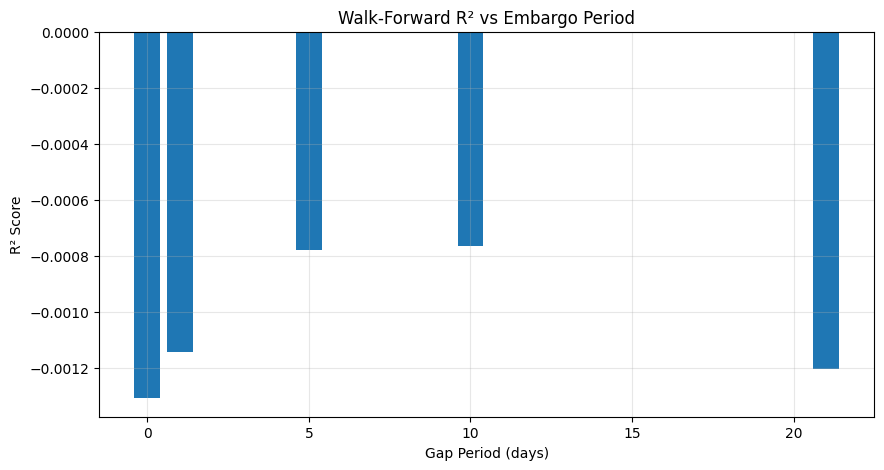


💡 Small drops in R² with gap suggest some information leakage without gap


In [5]:
# Demonstrate gap effect
gaps = [0, 1, 5, 10, 21]
results_by_gap = []

for gap in gaps:
    cv = WalkForwardCV(train_size=252, test_size=21, gap=gap, expanding=True)
    preds, actuals, metrics = walk_forward_backtest(X, y, Ridge(alpha=1.0), cv)
    
    r2 = r2_score(actuals, preds)
    results_by_gap.append({
        'gap': gap,
        'r2': r2,
        'n_folds': len(metrics)
    })

results_df = pd.DataFrame(results_by_gap)
print("📊 EFFECT OF EMBARGO/GAP PERIOD")
print("=" * 50)
print(results_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 5))
plt.bar(results_df['gap'], results_df['r2'])
plt.xlabel('Gap Period (days)')
plt.ylabel('R² Score')
plt.title('Walk-Forward R² vs Embargo Period')
plt.grid(True, alpha=0.3)
plt.show()

print("\n💡 Small drops in R² with gap suggest some information leakage without gap")

## 5. Convert Predictions to Trading Strategy

📊 WALK-FORWARD STRATEGY PERFORMANCE
Gross Sharpe: 2.63
Net Sharpe (10 bps): 2.62
Total Turnover: 1


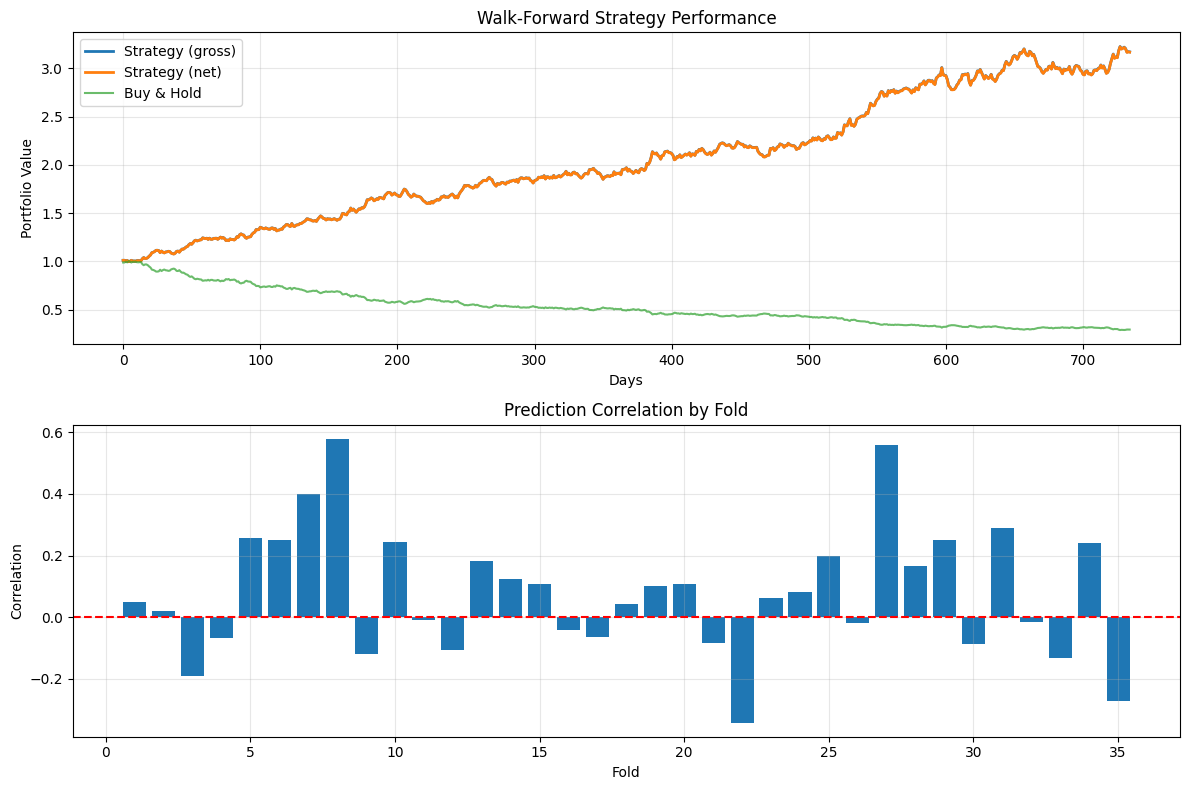

In [6]:
def predictions_to_strategy(predictions, actuals, cost_bps=10):
    """
    Convert predictions to trading signals and calculate performance
    """
    # Signal: Long if predict positive, short if negative
    signals = np.sign(predictions)
    
    # Strategy returns
    gross_returns = signals * actuals
    
    # Add costs
    position_changes = np.abs(np.diff(signals, prepend=0))
    costs = position_changes * (cost_bps / 10000)
    net_returns = gross_returns - costs
    
    # Metrics
    sharpe_gross = np.mean(gross_returns) / np.std(gross_returns) * np.sqrt(252)
    sharpe_net = np.mean(net_returns) / np.std(net_returns) * np.sqrt(252)
    
    return {
        'signals': signals,
        'gross_returns': gross_returns,
        'net_returns': net_returns,
        'sharpe_gross': sharpe_gross,
        'sharpe_net': sharpe_net,
        'turnover': position_changes.sum()
    }

# Apply to our walk-forward results
strategy = predictions_to_strategy(preds_exp, actuals_exp, cost_bps=10)

print("📊 WALK-FORWARD STRATEGY PERFORMANCE")
print("=" * 50)
print(f"Gross Sharpe: {strategy['sharpe_gross']:.2f}")
print(f"Net Sharpe (10 bps): {strategy['sharpe_net']:.2f}")
print(f"Total Turnover: {strategy['turnover']:.0f}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Cumulative returns
cum_gross = (1 + pd.Series(strategy['gross_returns'])).cumprod()
cum_net = (1 + pd.Series(strategy['net_returns'])).cumprod()
cum_buyhold = (1 + pd.Series(actuals_exp)).cumprod()

axes[0].plot(cum_gross.values, label='Strategy (gross)', linewidth=2)
axes[0].plot(cum_net.values, label='Strategy (net)', linewidth=2)
axes[0].plot(cum_buyhold.values, label='Buy & Hold', alpha=0.7)
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Portfolio Value')
axes[0].set_title('Walk-Forward Strategy Performance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Fold performance
axes[1].bar(metrics_exp['fold'], metrics_exp['correlation'])
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Correlation')
axes[1].set_title('Prediction Correlation by Fold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. ⏱️ TIMED CODING CHALLENGE (30 minutes)

**Challenge:** Implement a `PurgedKFold` class that:
1. Creates time-series aware folds
2. Purges overlapping samples between train and test
3. Supports embargo periods
4. Returns proper train/test indices

In [7]:
# YOUR CODE HERE
class PurgedKFold:
    """
    Purged K-Fold for time series with overlapping labels
    
    Removes training samples that would leak into test period
    """
    def __init__(self, n_splits=5, embargo=0):
        # TODO: Implement
        pass
    
    def split(self, X, y=None, groups=None):
        """Generate purged train/test indices"""
        # TODO: Implement
        pass
    
    def get_n_splits(self, X=None, y=None, groups=None):
        # TODO: Implement
        pass

# Test your implementation
# purged_cv = PurgedKFold(n_splits=5, embargo=5)
# for train_idx, test_idx in purged_cv.split(X):
#     print(f"Train: {len(train_idx)}, Test: {len(test_idx)}")

## 7. Interview Question of the Day

**Q: Explain the difference between expanding and rolling window walk-forward validation. When would you use each?**

Think about:
1. Data efficiency vs adaptability
2. Regime changes in markets
3. Model stability requirements

In [8]:
# Compare expanding vs rolling in presence of regime change
# Simulate regime change: first half has different relationship

n = 800
X_regime = np.random.randn(n, 4)

# First regime: feature 0 is predictive
y_regime = np.zeros(n)
y_regime[:400] = 0.1 * X_regime[:400, 0] + np.random.randn(400) * 0.01
# Second regime: feature 1 is predictive  
y_regime[400:] = 0.1 * X_regime[400:, 1] + np.random.randn(400) * 0.01

# Compare
expanding_cv = WalkForwardCV(train_size=200, test_size=20, gap=1, expanding=True)
rolling_cv = WalkForwardCV(train_size=200, test_size=20, gap=1, expanding=False)

_, _, metrics_exp = walk_forward_backtest(X_regime, y_regime, Ridge(alpha=1.0), expanding_cv)
_, _, metrics_roll = walk_forward_backtest(X_regime, y_regime, Ridge(alpha=1.0), rolling_cv)

print("📊 REGIME CHANGE SCENARIO")
print("=" * 60)
print("First 400 samples: Feature 0 predictive")
print("Last 400 samples: Feature 1 predictive")
print("-" * 60)
print(f"Expanding window mean R²: {metrics_exp['r2'].mean():.4f}")
print(f"Rolling window mean R²: {metrics_roll['r2'].mean():.4f}")
print("\n💡 Rolling window adapts better to regime changes!")

📊 REGIME CHANGE SCENARIO
First 400 samples: Feature 0 predictive
Last 400 samples: Feature 1 predictive
------------------------------------------------------------
Expanding window mean R²: 0.1739
Rolling window mean R²: 0.6922

💡 Rolling window adapts better to regime changes!


## 8. Key Takeaways

| Concept | Key Point |
|---------|-----------|
| K-Fold CV | WRONG for time series - causes lookahead |
| Walk-Forward | Train always before test - realistic |
| Expanding | Uses all history - more data but less adaptive |
| Rolling | Fixed window - adapts to regime changes |
| Embargo | Gap between train/test - prevents leakage |

---

**Tomorrow:** Backtesting Best Practices